<a href="https://colab.research.google.com/github/nw93929/DS3001Project/blob/main/randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Name:** Nathan Wan

## **Computing ID:** xsj5rs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

!pip install lime
from lime import lime_tabular
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Project Model 1: Winner Prediction using Random Forest

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/17jL6-gLQWYkZJZGzAduIlU4YET0u2Ek-?usp=sharing)

# **Part 1: Data Preparation**

In [ ]:
data = pd.read_csv("2019-20_pbp.csv").drop(["URL", "Time", "Unnamed: 40"], axis=1)
player_columns = [col for col in data.columns if 'player' in col.lower()]
data_cleaned = data.drop(columns=player_columns)
data_cleaned.head()

,GameType,Location,Date,WinningTeam,Quarter,SecLeft,AwayTeam,AwayPlay,AwayScore,HomeTeam,...,TimeoutTeam,FreeThrowShooter,FreeThrowOutcome,FreeThrowNum,EnterGame,LeaveGame,TurnoverType,TurnoverCause,TurnoverCauser,JumpballPoss
0,regular,Scotiabank Arena Toronto Canada,October 22 2019,TOR,1,720,NOP,Jump ball: D. Favors vs. M. Gasol (L. Ball gai...,0,TOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L. Ball - balllo01
1,regular,Scotiabank Arena Toronto Canada,October 22 2019,TOR,1,708,NOP,L. Ball misses 2-pt jump shot from 11 ft,0,TOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,regular,Scotiabank Arena Toronto Canada,October 22 2019,TOR,1,707,NOP,Offensive rebound by D. Favors,0,TOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,regular,Scotiabank Arena Toronto Canada,October 22 2019,TOR,1,707,NOP,D. Favors makes 2-pt layup at rim,2,TOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,regular,Scotiabank Arena Toronto Canada,October 22 2019,TOR,1,689,NOP,NaN,2,TOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.fillna({
    'HomePlay': '',
    'AwayPlay': '',
}, inplace=True)
data['HomeWinner'] = data.apply(
    lambda row: 1 if row['WinningTeam'] == row['HomeTeam'] else 0,
    axis=1
)
data['PlayoffGame'] = data.apply(
    lambda row: 1 if row['GameType'] == "playoff" else 0,
    axis=1
)

def shot_distance(dist):
    if dist <= 4:
        return 'Close'
    elif dist <= 14:
        return 'Mid-Range'
    elif dist <= 24:
        return 'Three-Point Range'
    elif dist <= 47:
        return 'Long Shot'
    else:
        return 'Nothing to Lose'

data['ShotDist'] = data['ShotDist'].apply(shot_distance)

data['TimeLeft'] = (4 - data['Quarter']) * 720 + data['SecLeft']
data = data[data['TimeLeft'] > 720]
data['ScoreDiff'] = data['HomeScore'] - data['AwayScore']
data = data.drop(["HomeScore","AwayScore", "Quarter", "SecLeft", "Date", "WinningTeam", "AwayTeam", "HomeTeam", "GameType", "Location", "AwayPlay", "HomePlay", "Fouled","EnterGame","LeaveGame","JumpballAwayPlayer","JumpballHomePlayer"], axis=1)
display(data.head())

<ipython-input-16-36f1f34c0c14>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ScoreDiff'] = data['HomeScore'] - data['AwayScore']


,Shooter,ShotType,ShotOutcome,ShotDist,Assister,Blocker,FoulType,Fouler,Rebounder,ReboundType,...,FreeThrowNum,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser,JumpballPoss,HomeWinner,PlayoffGame,TimeLeft,ScoreDiff
0,NaN,NaN,NaN,Nothing to Lose,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,L. Ball - balllo01,1,0,2880,0
1,L. Ball - balllo01,2-pt jump shot,miss,Mid-Range,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2868,0
2,NaN,NaN,NaN,Nothing to Lose,NaN,NaN,NaN,NaN,D. Favors - favorde01,offensive,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2867,0
3,D. Favors - favorde01,2-pt layup,make,Close,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2867,-2
4,O. Anunoby - anunoog01,2-pt layup,miss,Close,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2849,-2


In [ ]:
high_importance_features = [
    'Shooter',
    'ShotType',
    'ShotOutcome',
    'ShotDist',
    'Blocker',
    'FoulType',
    'FreeThrowOutcome',
    'TurnoverType',
    'HomeWinner',
    'PlayoffGame',
    'TimeLeft',
    'ScoreDiff'
]

data = data[high_importance_features].fillna('NA')

In [ ]:
player_frequency = data['Shooter'].value_counts()
data['Shooter_encoded'] = data['Shooter'].map(player_frequency)
player_frequency = data['Blocker'].value_counts()
data['Blocker_encoded'] = data['Blocker'].map(player_frequency)

data = pd.get_dummies(data, columns=['ShotType', 'ShotOutcome', 'ShotDist', 'FoulType', 'FreeThrowOutcome', 'TurnoverType'])
data = data.drop(['Shooter', 'Blocker'], axis=1)

display(data.head())
data.shape

,HomeWinner,PlayoffGame,TimeLeft,ScoreDiff,Shooter_encoded,Blocker_encoded,ShotType_2-pt dunk,ShotType_2-pt hook shot,ShotType_2-pt jump shot,ShotType_2-pt layup,...,TurnoverType_lane violation,TurnoverType_lost ball,TurnoverType_off goaltending,TurnoverType_offensive foul,TurnoverType_out of bounds lost ball,TurnoverType_palming,TurnoverType_shot clock,TurnoverType_step out of bounds,TurnoverType_traveling,TurnoverType_turnover
0,1,0,2880,0,241165,385044,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0,2868,0,537,385044,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,1,0,2867,0,241165,385044,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,0,2867,-2,278,385044,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,1,0,2849,-2,557,385044,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


(393296, 53)

In [ ]:
print(data['HomeWinner'].value_counts(normalize=True))

HomeWinner
1    0.547415
0    0.452585
Name: proportion, dtype: float64


# **Part 2: Random Forest**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score

y = data['HomeWinner']
X = data.drop('HomeWinner', axis=1)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score

def random_forest_model(X, y, pos_label,
                        n_estimators=100,
                        max_depth=None,
                        min_samples_split=2,
                        min_samples_leaf=1,
                        random_state=3001):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Feature importances
    importances = model.feature_importances_
    feature_importances = pd.Series(importances, index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False).head(25)


    feature_importances.sort_values().plot(kind='barh', title='Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    # Metrics
    precision = precision_score(y_test, y_pred, average='binary', pos_label=pos_label)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=pos_label)
    accuracy = accuracy_score(y_test, y_pred)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Accuracy: ", accuracy)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3001)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
dt_model = DecisionTreeClassifier(random_state=3001)
dt_model.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
rf_model = RandomForestClassifier(random_state=3001)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Vanilla Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Vanilla Random Forest Accuracy: {rf_accuracy:.4f}")

accuracies = []

param_grid = [
    {'n_estimators': [50, 100], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
    {'n_estimators': [100, 200], 'max_depth': [None, 10, 15], 'min_samples_split': [2, 10], 'min_samples_leaf': [1, 3]},
    {'n_estimators': [50, 100], 'max_depth': [3, 7, 10], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 3]},
    {'n_estimators': [150], 'max_depth': [None, 3], 'min_samples_split': [5], 'min_samples_leaf': [1]},
    {'n_estimators': [100], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [2]},
    {'n_estimators': [150], 'max_depth': [5], 'min_samples_split': [5], 'min_samples_leaf': [1]},
    {'n_estimators': [200], 'max_depth': [10], 'min_samples_split': [2], 'min_samples_leaf': [3]},
    {'n_estimators': [50], 'max_depth': [None], 'min_samples_split': [3], 'min_samples_leaf': [2]},
    {'n_estimators': [100], 'max_depth': [7], 'min_samples_split': [4], 'min_samples_leaf': [2]},
    {'n_estimators': [1000], 'max_depth': [None], 'min_samples_split': [10], 'min_samples_leaf': [5]}
]

for params in param_grid:
    rf_model = RandomForestClassifier(
        n_estimators=params['n_estimators'][0],
        max_depth=params['max_depth'][0],
        min_samples_split=params['min_samples_split'][0],
        min_samples_leaf=params['min_samples_leaf'][0],
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    rf_y_pred = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_y_pred)

    accuracies.append(rf_accuracy)

# Print the best accuracy from the tuned models
max_accuracy = max(accuracies)
print(f"Maximum Accuracy from Tuned Random Forest models: {max_accuracy:.4f}")

Vanilla Decision Tree Accuracy: 0.6571
Vanilla Random Forest Accuracy: 0.6695
Maximum Accuracy from Tuned Random Forest models: 0.6916


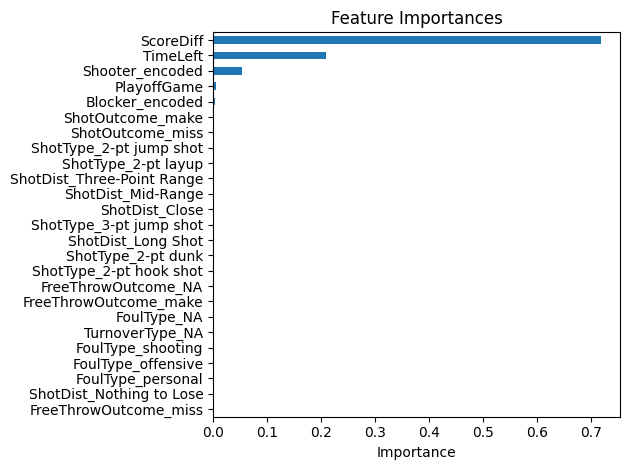

Precision:  0.7084894432935162
Recall:  0.7457316507376821
Accuracy:  0.6924993643529113


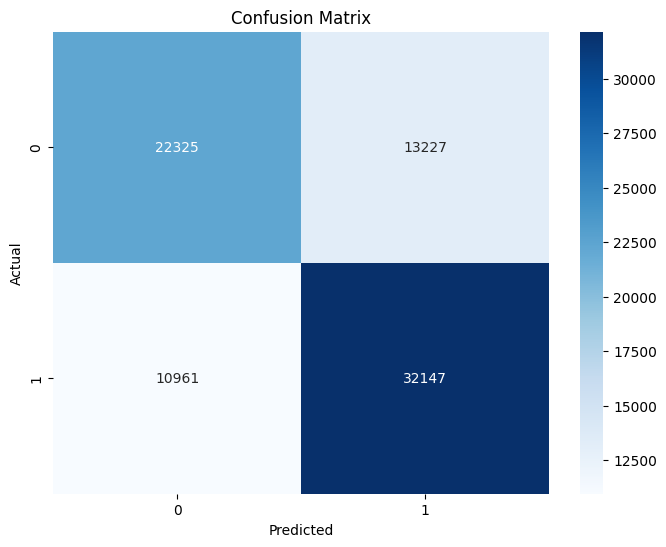

In [ ]:
random_forest_model(X, y, pos_label = 1,
                        n_estimators=1000,
                        max_depth=None,
                        min_samples_split=10,
                        min_samples_leaf=10,
                        random_state=3001)